In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Splitting data into train, test and validation sets...
Data split successfully!


In [6]:
def inception_module(x, filters: list[int]):
    tower_1 = keras.layers.Conv2D(filters[0], (1, 1), padding="same", activation="relu")(x)
    tower_1 = keras.layers.Conv2D(filters[1], (3, 3), padding="same", activation="relu")(tower_1)

    tower_2 = keras.layers.Conv2D(filters[2], (1, 1), padding="same", activation="relu")(x)
    tower_2 = keras.layers.Conv2D(filters[3], (5, 5), padding="same", activation="relu")(tower_2)

    tower_3 = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
    tower_3 = keras.layers.Conv2D(filters[4], (1, 1), padding="same", activation="relu")(tower_3)

    tower_4 = keras.layers.Conv2D(filters[5], (1, 1), padding="same", activation="relu")(x)

    concatenated = keras.layers.Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
    return concatenated


def build_google_net(model_name: str):
    input_layer = keras.layers.Input(shape=preprocessing_utils.images.shape[1:])

    x = keras.layers.Conv2D(
        64, (7, 7), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(input_layer)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Conv2D(
        64, (1, 1), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.Conv2D(
        192, (3, 3), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_module(x, [64, 128, 32, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(preprocessing_utils.num_classes, activation="softmax")(x)

    model = keras.models.Model(name=model_name, inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [7]:
google_net_wrapper = ModelWrapper("GoogleNet", preprocessing_utils=preprocessing_utils)

In [8]:
google_net_wrapper.build_model(build_fn=build_google_net, model_name=google_net_wrapper.model_name)

Building model...
Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                        

In [9]:
google_net_wrapper.train_and_save_model_and_history(batch_size=32)

Epoch 1/100
129/129 [==============================] - ETA: 0s - loss: 3.8452 - accuracy: 0.0710
Epoch 1: val_loss improved from inf to 3.78617, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 14s 59ms/step - loss: 3.8452 - accuracy: 0.0710 - val_loss: 3.7862 - val_accuracy: 0.0783 - lr: 0.0100
Epoch 2/100
127/129 [============================>.] - ETA: 0s - loss: 3.7966 - accuracy: 0.0709
Epoch 2: val_loss improved from 3.78617 to 3.75392, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 9s 68ms/step - loss: 3.7963 - accuracy: 0.0705 - val_loss: 3.7539 - val_accuracy: 0.0599 - lr: 0.0100
Epoch 3/100
127/129 [============================>.] - ETA: 0s - loss: 3.7356 - accuracy: 0.0878
Epoch 3: val_loss improved from 3.75392 to 3.64064, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 50ms/step - loss: 3.7351 - accuracy: 0.0873 - val_loss: 3.6406 - val_accuracy: 0.0829 - lr: 0.0100
Epoch 4/100
127/129 [============================>.] - ETA: 0s - loss: 3.5790 - accuracy: 0.1284
Epoch 4: val_loss improved from 3.64064 to 3.50489, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 47ms/step - loss: 3.5778 - accuracy: 0.1284 - val_loss: 3.5049 - val_accuracy: 0.0922 - lr: 0.0100
Epoch 5/100
128/129 [============================>.] - ETA: 0s - loss: 3.4046 - accuracy: 0.1687
Epoch 5: val_loss improved from 3.50489 to 3.32383, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 47ms/step - loss: 3.4042 - accuracy: 0.1688 - val_loss: 3.3238 - val_accuracy: 0.1521 - lr: 0.0100
Epoch 6/100
128/129 [============================>.] - ETA: 0s - loss: 3.2181 - accuracy: 0.2219
Epoch 6: val_loss improved from 3.32383 to 3.21703, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 45ms/step - loss: 3.2193 - accuracy: 0.2216 - val_loss: 3.2170 - val_accuracy: 0.2120 - lr: 0.0100
Epoch 7/100
127/129 [============================>.] - ETA: 0s - loss: 3.0558 - accuracy: 0.2591
Epoch 7: val_loss improved from 3.21703 to 3.08191, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 45ms/step - loss: 3.0558 - accuracy: 0.2591 - val_loss: 3.0819 - val_accuracy: 0.2120 - lr: 0.0100
Epoch 8/100
129/129 [==============================] - ETA: 0s - loss: 2.8690 - accuracy: 0.2958
Epoch 8: val_loss improved from 3.08191 to 2.97564, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 46ms/step - loss: 2.8690 - accuracy: 0.2958 - val_loss: 2.9756 - val_accuracy: 0.2811 - lr: 0.0100
Epoch 9/100
128/129 [============================>.] - ETA: 0s - loss: 2.7443 - accuracy: 0.3335
Epoch 9: val_loss improved from 2.97564 to 2.90402, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 46ms/step - loss: 2.7438 - accuracy: 0.3337 - val_loss: 2.9040 - val_accuracy: 0.3226 - lr: 0.0100
Epoch 10/100
127/129 [============================>.] - ETA: 0s - loss: 2.5465 - accuracy: 0.3959
Epoch 10: val_loss improved from 2.90402 to 2.86261, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 46ms/step - loss: 2.5464 - accuracy: 0.3950 - val_loss: 2.8626 - val_accuracy: 0.3364 - lr: 0.0100
Epoch 11/100
129/129 [==============================] - ETA: 0s - loss: 2.3181 - accuracy: 0.4500
Epoch 11: val_loss improved from 2.86261 to 2.80529, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 47ms/step - loss: 2.3181 - accuracy: 0.4500 - val_loss: 2.8053 - val_accuracy: 0.3318 - lr: 0.0100
Epoch 12/100
128/129 [============================>.] - ETA: 0s - loss: 2.1693 - accuracy: 0.4919
Epoch 12: val_loss improved from 2.80529 to 2.74129, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 6s 46ms/step - loss: 2.1703 - accuracy: 0.4919 - val_loss: 2.7413 - val_accuracy: 0.3364 - lr: 0.0100
Epoch 13/100
127/129 [============================>.] - ETA: 0s - loss: 1.9399 - accuracy: 0.5701
Epoch 13: val_loss did not improve from 2.74129
129/129 [==============================] - 3s 27ms/step - loss: 1.9367 - accuracy: 0.5707 - val_loss: 2.8157 - val_accuracy: 0.3548 - lr: 0.0100
Epoch 14/100
127/129 [============================>.] - ETA: 0s - loss: 1.7885 - accuracy: 0.6302
Epoch 14: val_loss did not improve from 2.74129
129/129 [==============================] - 3s 26ms/step - loss: 1.7911 - accuracy: 0.6286 - val_loss: 2.8361 - val_accuracy: 0.3917 - lr: 0.0100
Epoch 15/100
128/129 [============================>.] - ETA: 0s - loss: 1.6108 - accuracy: 0.6887
Epoch 15: val_loss did not improve from 2.74129
129/129 [==============================] - 3s 26ms/step - loss: 1.6134 - accuracy: 0.6882 - val_loss: 3.0806 - val_accuracy: 0.

In [10]:
google_net_wrapper.load_model_and_history()

Loading model from "../../artifacts/models/GoogleNet.h5"...
Model loaded successfully!
Loading history from "../../artifacts/model_histories/history_GoogleNet"...
History loaded successfully!


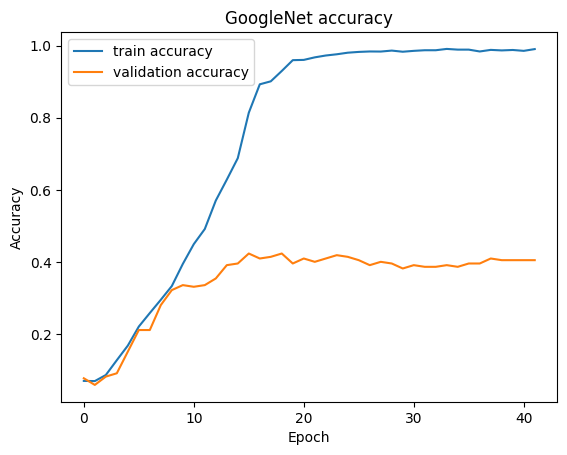

In [11]:
google_net_wrapper.plot_accuracy()

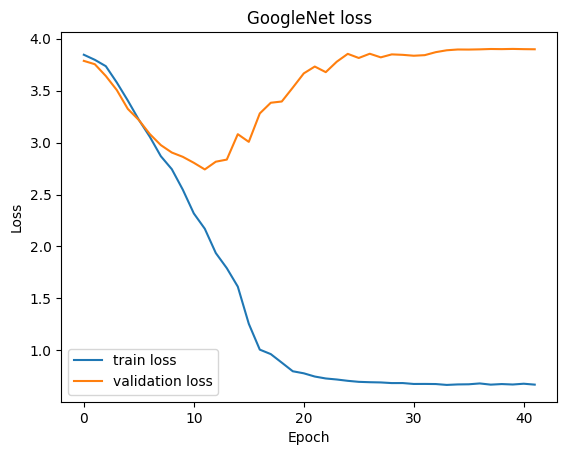

In [12]:
google_net_wrapper.plot_loss()

20/20 [==============================] - 1s 22ms/step - loss: 3.6704 - accuracy: 0.4669
Loss: 3.6704
Accuracy: 0.4669
20/20 [==============================] - 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.43      0.52      0.47        25
           2       0.65      0.69      0.67        52
           3       0.31      0.29      0.30        38
           4       0.43      0.33      0.38        27
           5       0.39      0.51      0.44        35
           6       0.41      0.31      0.35        45
           7       0.17      0.30      0.21        10
           8       0.57      0.67      0.62        12
           9       0.56      0.45      0.50        11
          10       0.45      0.39      0.42        23
          11       0.40      0.54      0.46        26
          12       0.38      0.47      0.42        32
          13       0.30      0.40      0.34     

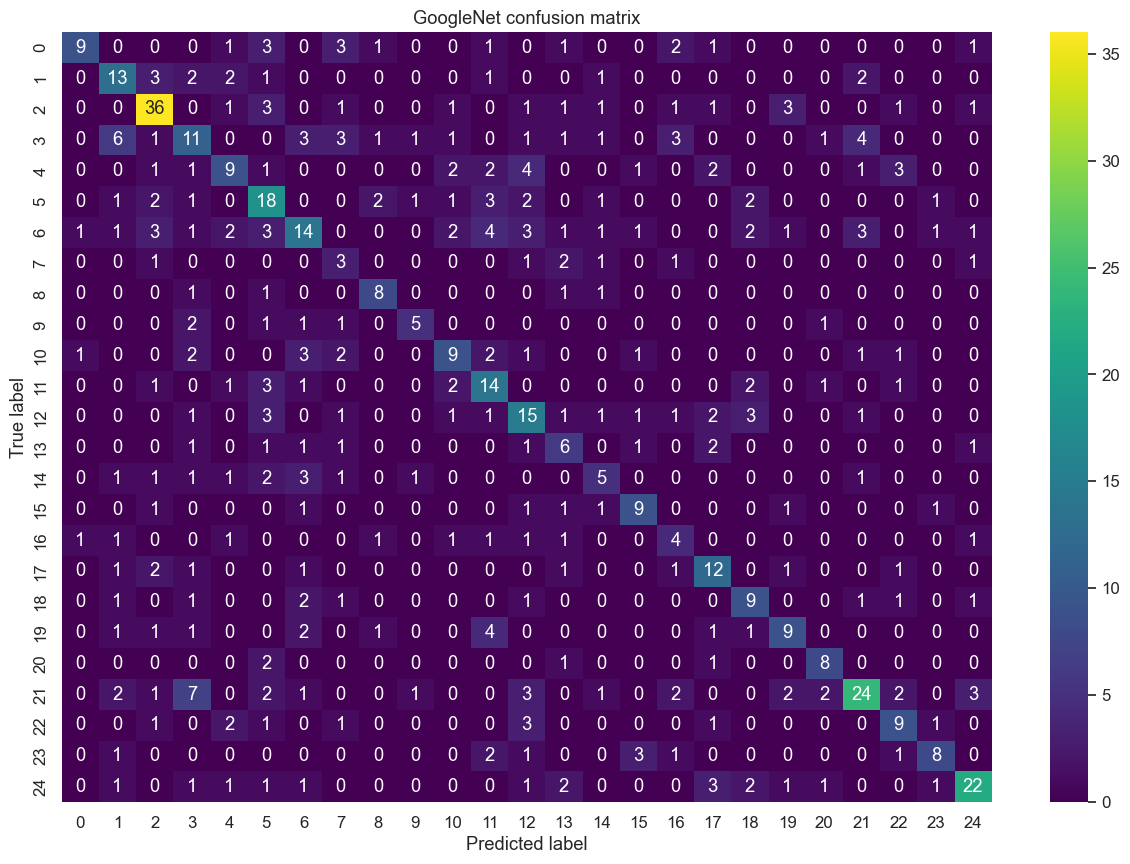

In [13]:
google_net_wrapper.display_evaluation_results()